
# How to check all possible target binding sites against off-target binding sites in whole transcriptome
We have a target mRNA that we want to bind with RNA binding proteins. To design these pumby proteins we need to select binding sites on our target mRNA which are very unique, i.e. ideally dont occure elsewhere the transcriptome.  Or more general: We have a target sequence and we want to find a subsequence of specified length which is as specific to this target as possible i.e. has the least interactions with dataset of reference sequences. 


In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from time import time
import warnings
import pathlib
import scipy.stats as stats
from joblib import Parallel, delayed
from tqdm import tqdm
import math
from main_search import sc_jit, query_sc_summary, sc_summarize, query_sc, df_PCA, df_map, df_table, _col_weights
from numba import njit
from IPython.display import display
from sequence_reader import read_fasta, _ensembl_fasta_to_dict

## Import data


#### General Fasta importer - mCherry Sequencing results

In [2]:
mCherry = read_fasta("sequence_data/iGEM_mCherry_V2.fasta").iloc[0]
mCherry.SEQUENCE = mCherry.SEQUENCE.upper()
mCherry

SEQ_NAME                               iGEM_mCherry_BBa_E2060
SEQUENCE    ATGGCAACTAGCGGCATGGTTAGTAAAGGAGAAGAAAATAACATGG...
Name: 0, dtype: object

#### read ensembl FASTA and decode description
 - for FASTA data from https://ftp.ensembl.org/pub/

In [3]:
files = ["sequence_data/Saccharomyces_cerevisiae.R64-1-1.ncrna.fa", "sequence_data/Saccharomyces_cerevisiae.R64-1-1.cdna.all.fa", "sequence_data/Saccharomyces_cerevisiae.R64-1-1.cds.all.fa"]  # -> different transcripts in each DataFrame -> data has to be concatenated
_df = pd.concat([read_fasta(file) for file in files], ignore_index=True)
df_seq = pd.concat([_df.SEQ_NAME.apply(_ensembl_fasta_to_dict).apply(pd.Series), _df.SEQUENCE], axis = 1).drop_duplicates(ignore_index = True) # split description into respective columns i.e. decode ensebl fasta description
df_seq

SEQ_NAME                     chromosome     gene    gene_biotype  \
0      ETS2-2_rRNA   R64-1-1:XII:460712:460922:-1   ETS2-2            rRNA   
1      ITS2-2_rRNA   R64-1-1:XII:464319:464550:-1   ITS2-2            rRNA   
2     RDN18-1_rRNA   R64-1-1:XII:455933:457732:-1  RDN18-1            rRNA   
3       Q0020_rRNA       R64-1-1:Mito:6546:8194:1    Q0020            rRNA   
4      RDN5-5_rRNA    R64-1-1:XII:485697:485815:1   RDN5-5            rRNA   
...            ...                            ...      ...             ...   
7035       YIL170W       R64-1-1:IX:19847:21220:1  YIL170W      pseudogene   
7036  YMR242C_mRNA  R64-1-1:XIII:753225:753742:-1  YMR242C  protein_coding   
7037  YOR312C_mRNA    R64-1-1:XV:900250:900767:-1  YOR312C  protein_coding   
7038  YJL041W_mRNA      R64-1-1:X:365903:368373:1  YJL041W  protein_coding   
7039  YIL111W_mRNA     R64-1-1:IX:155311:155765:1  YIL111W  protein_coding   

     transcript_biotype                                           SEQUENCE  
0                   NaN  TTTTTATTTCTTTCTAAGTGGGTACTGGCAGGAGCCGGGGCCTAGT...  
1                   NaN  CCTTCTCAAACATTCTGTTTGGTAGTGAGTGATACTCTTTGGAGTT...  
2                   NaN  TATCTGGTTGATCCTGCCAGTAGTCATATGCTTGTCTCAAAGATTA...  
3                  rRNA  GTAAAAAATTTATAAGAATATGATGTTGGTTCAGATTAAGCGCTAA...  
4                   NaN  GGTTGCGGCCATATCTACCAGAAAGCACCGTTTCCCGTCCGATCAA...  
...                 ...                                                ...  
7035         pseudogene  ATGGGTTTGATTGTCTCAATATTCAACATTGGCTGCGCCATAGGCG...  
7036     protein_coding  GCTCACTTTAAAGAATACCAAGTTATTGGCCGTCGTTTGCCAACTG...  
7037     protein_coding  GCTCATTTCAAAGAATACCAAGTCATTGGTCGTCGTTTACCAACTG...  
7038     protein_coding  AACTTCAATACACCTCAACAAAACAAAACGCCCTTTTCGTTCGGGA...  
7039     protein_coding  TTGCGTACTTCTCTTACTAAAGGGGCACGGCTAACTGGGACAAGAT...  

[7040 rows x 6 columns]

#### read TPM.tsv files - quantitative transcriptome
data from https://www.ebi.ac.uk/gxa/experiments?species=%22saccharomyces+cerevisiae%22&experimentType=%22Baseline%22

In [4]:
files = ["sequence_data/E-MTAB-8621-query-results.tpms.tsv", "sequence_data/E-MTAB-8626-query-results.tpms.tsv"] # same genes under different conditions -> data has to be merged
_df = pd.read_csv(files[0], sep = '\t', skiprows = 4)
for file in files[1:]:
    _df = pd.merge(_df, pd.read_csv(file, sep = '\t', skiprows = 4) , how = "outer", on = ["Gene ID", "Gene Name"])

df_tpm = _df.drop(columns = _df.filter(like="minute").columns) # combine timeseries data by taking the max of the found expression
df_tpm["tpm_max"] = _df.filter(like="minute").max(axis = 1, skipna = True, numeric_only = True)
df_tpm

Gene ID Gene Name  tpm_max
0        ETS1-1    ETS1-1     72.0
1        ETS1-2    ETS1-2      3.0
2        ETS2-1    ETS2-1      8.0
3          HRA1      HRA1      3.0
4          ICR1      ICR1      5.0
...         ...       ...      ...
6782  tY(GUA)F2      SUP6      3.0
6783  tY(GUA)J1      SUP7      9.0
6784  tY(GUA)J2      SUP4      3.0
6785  tY(GUA)M1      SUP5      6.0
6786   tY(GUA)O      SUP3      3.0

[6787 rows x 3 columns]

### merge sequence and tpm data

In [5]:
transcriptome = pd.merge(df_seq, df_tpm, left_on="gene", right_on="Gene ID", how = "outer") 
transcriptome = transcriptome[~transcriptome.SEQUENCE.isna()]                               # delete entries witho9ut a sequence
transcriptome.loc[transcriptome.tpm_max.isna(), "tpm_max"] = transcriptome.tpm_max.max()                   # if transcript count (TPM) is unknown, expect the worst
transcriptome["WEIGHT"] = transcriptome.tpm_max
mCherry["WEIGHT"] = transcriptome.tpm_max.mean()
transcriptome

SEQ_NAME                    chromosome       gene gene_biotype  \
0        ETS1-1_rRNA  R64-1-1:XII:457733:458432:-1     ETS1-1         rRNA   
1        ETS1-2_rRNA  R64-1-1:XII:466870:467569:-1     ETS1-2         rRNA   
2        ETS2-1_rRNA  R64-1-1:XII:451575:451785:-1     ETS2-1         rRNA   
3        ETS2-2_rRNA  R64-1-1:XII:460712:460922:-1     ETS2-2         rRNA   
4         HRA1_ncRNA       R64-1-1:I:99305:99868:1       HRA1        ncRNA   
...              ...                           ...        ...          ...   
7083  tY(GUA)J2_tRNA    R64-1-1:X:542956:543044:-1  tY(GUA)J2         tRNA   
7084  tY(GUA)M1_tRNA  R64-1-1:XIII:168795:168883:1  tY(GUA)M1         tRNA   
7085  tY(GUA)M2_tRNA  R64-1-1:XIII:837928:838016:1  tY(GUA)M2         tRNA   
7086   tY(GUA)O_tRNA    R64-1-1:XV:288192:288280:1   tY(GUA)O         tRNA   
7087   tY(GUA)Q_tRNA    R64-1-1:Mito:70824:70907:1   tY(GUA)Q         tRNA   

     transcript_biotype                                           SEQUENCE  \
0                   NaN  ATGCGAAAGCAGTTGAAGACAAGTTCGAAAAGAGTTTGGAAACGAA...   
1                   NaN  ATGCGAAAGCAGTTGAAGACAAGTTCGAAAAGAGTTTGGAAACGAA...   
2                   NaN  TTTTTATTTCTTTCTAAGTGGGTACTGGCAGGAGCCGGGGCCTAGT...   
3                   NaN  TTTTTATTTCTTTCTAAGTGGGTACTGGCAGGAGCCGGGGCCTAGT...   
4                   NaN  GGGCCCTTTCTTCCGTTTGAACGTAAAGGCATTTTTGAGACCATTA...   
...                 ...                                                ...   
7083               tRNA  CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAAATCTTGA...   
7084               tRNA  CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAAATCTTGA...   
7085               tRNA  CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAAATCTTGA...   
7086               tRNA  CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAAATCTTGA...   
7087                NaN  GGAGGGATTTTCAATGTTGGTAGTTGGAGTTGAGCTGTAAACTCAA...   

        Gene ID Gene Name  tpm_max   WEIGHT  
0        ETS1-1    ETS1-1     72.0     72.0  
1        ETS1-2    ETS1-2      3.0      3.0  
2        ETS2-1    ETS2-1      8.0      8.0  
3           NaN       NaN  22546.0  22546.0  
4          HRA1      HRA1      3.0      3.0  
...         ...       ...      ...      ...  
7083  tY(GUA)J2      SUP4      3.0      3.0  
7084  tY(GUA)M1      SUP5      6.0      6.0  
7085        NaN       NaN  22546.0  22546.0  
7086   tY(GUA)O      SUP3      3.0      3.0  
7087        NaN       NaN  22546.0  22546.0  

[7040 rows x 10 columns]

### Load mcherry secondary structure scores

In [6]:
mCherry_secstructure = pd.read_csv("sequence_data/mcherry-rna-secstructure-CasRxguides.csv").rename(columns={'GuideSeq': 'SEQUENCE', 'GuideName': 'SEQ_NAME', 'MatchPos':'POSITION' })
mCherry_secstructure["WEIGHT"] = 1

<br>
<br>
<br>

# Search for off-target binding-sites on single transcript 
= global sequence comparison of query with a reference sequence
- as we are searching for binding sites in the transcriptome, we'd ideally find as few as possible to avoid unwanted side-effects.
- As the binding sites are usually shorter then the persistence length of the polymers, a global sequence alignment search should suffice (we dont need BLAST)

In [7]:
query = mCherry_secstructure.sample().iloc[0]
ref = transcriptome.sample().iloc[0]
display(pd.DataFrame([query, ref]) )

SEQ_NAME                                           SEQUENCE  \
453   crRNA242:242-264                            GTCGGCGGGGTGCTTGACATAAG   
1358      YDR244W_mRNA  ATGGACGTAGGAAGTTGCTCAGTGGGAAATAATCCGCTTGCGCAGT...   

      POSITION  GuideScores    Rank  standardizedGuideScores  quartiles  \
453      264.0     0.228395  0.3729                 0.285715        2.0   
1358       NaN          NaN     NaN                      NaN        NaN   

      WEIGHT                  chromosome     gene    gene_biotype  \
453      1.0                         NaN      NaN             NaN   
1358   101.0  R64-1-1:IV:950563:952401:1  YDR244W  protein_coding   

     transcript_biotype  Gene ID Gene Name  tpm_max  
453                 NaN      NaN       NaN      NaN  
1358     protein_coding  YDR244W      PEX5    101.0

{'mismatch_eq_0': np.int64(0), 'mismatch_eq_1': np.int64(0), 'mismatch_eq_2': np.int64(0), 'boltzmann factor': np.float64(2.2015051379618026e-09)}


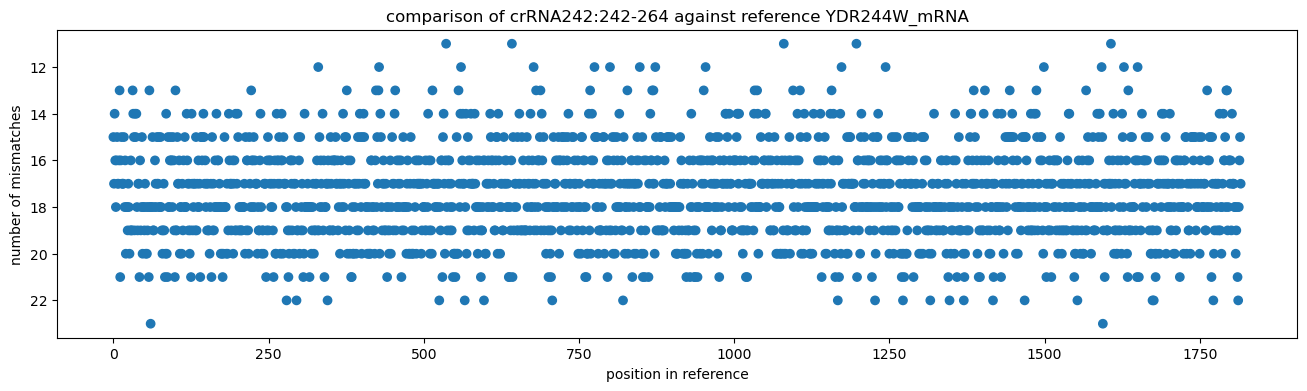

In [8]:

mm = len(query.SEQUENCE)-sc_jit(query.SEQUENCE.encode(), ref.SEQUENCE.encode()) # mm = number of mismatches at each possible binding position; encoding strings into bytes is faster for some reason; sc_jit returns the number of matches thats why mm = len - sc

sc_results = {}  # summarize the possible binding sites of the query sequence against one reference sequence i.e. a transcript from the transcriptome
sc_results["mismatch_eq_0"] = (mm==0).sum()                  # number of idential matches
sc_results["mismatch_eq_1"] = (mm==1).sum()                  # number of matches with 1 mismatch
sc_results["mismatch_eq_2"] = (mm==2).sum()                  # number of matches with 2 mistmatches
sc_results["boltzmann factor"] = np.sum(np.exp(-2.0*mm))     # a very basic prediction of how likely the query sequence would bind to the reference. The wildtype pumilios have ~ 18 hydrogen bonds for 8nt i.e. 2.25 hydgrogen bonds = 2.25kT per bp, however the pumby appears to only have ~2 H-bonds per bp, and the binding statistics suggest closer to 1kT -> lets go with 1.5 for now, in the future a more accurate model might be implemented. Currently the boltzmann_factor for a perfect match is 1, if therefore this predicted boltzmann_factor is smaller than 1 than it is more likly to bind to the specific RNA, while if it is larger than one it is more likely to bind to the background transcriptom 

if True:       
    plt.figure(figsize=(16, 4))
    plt.scatter(np.arange(mm.size), mm, c = np.array(["tab:red", "tab:green", "tab:orange", "tab:blue"])[np.clip(mm, 0, 3)])
    plt.gca().invert_yaxis()
    plt.ylabel("number of mismatches")
    plt.xlabel(f"position in reference")
    plt.title(f"comparison of {query.SEQ_NAME} against reference {ref.SEQ_NAME}")

print(sc_results)


## Test good candidate binding sequences (in parallel)
 - compare a selection of target-sequence substrings of specific length to reference dataset


In [9]:
# generate random input sequences for this test
reference_dataset = transcriptome        # The references to check against, i.e. the transcriptome in this example
target            = mCherry              # The sequence from which we want ot find the best/unique binding site
query_len = 12                           # length of the binding sites (usually 8-12 for pumby)

# only check possible binding sites with good secondary structure accessibility
query_dataset = mCherry_secstructure[mCherry_secstructure.quartiles == 4]


# compare possible binding sites against whole transcriptome
query_sc_summary(query_dataset.sample().iloc[0], reference_dataset, target) # testrun to make sure everything is ok, because for some stupid reason parallelised executions do not return warnings anymore
results = pd.DataFrame(list(tqdm(total=len(query_dataset), ncols = 100, 
        iterable=Parallel(return_as="generator", n_jobs=-1)(  # using joblib instead of multiprocessing becasue of windows compatibility
            delayed(query_sc_summary)(query, reference_dataset, target) for _, query in query_dataset.iterrows())
        )))

100%|█████████████████████████████████████████████████████████████| 138/138 [00:35<00:00,  3.87it/s]


In [11]:
df_PCA(results, exclude_cols = ["GuideScores", "Rank", "WEIGHT", "POSITION", "match"])

KeyError: "['identical match VIR', 'identical match W.VIR', '1nt mismatch VIR', '1nt mismatch W.VIR', '2nt mismatch VIR', '2nt mismatch W.VIR'] not found in axis"

# selection

 - select low nt mismatches first
 - select for locally for each 1/n segments of target seperatly to ensure good binding site distribution
 - filter out VIR duplicates at the end.

C:\Users\T3D\AppData\Local\Temp\ipykernel_11596\3471625881.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  selected = DF.index.isin(df.groupby('bin')['rank score'].nsmallest(nsmallest).reset_index(level=0, drop=True).index)


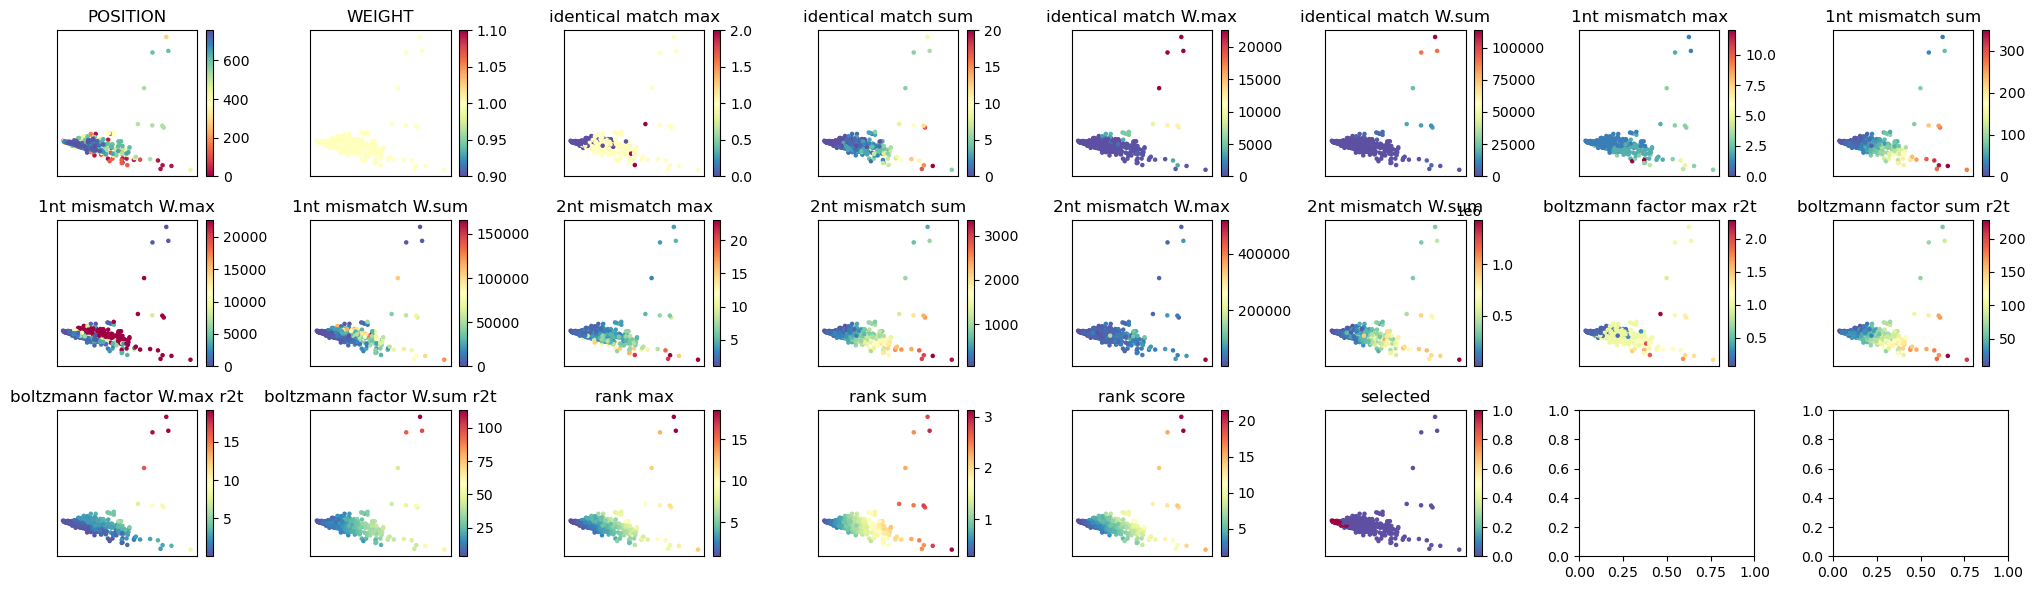

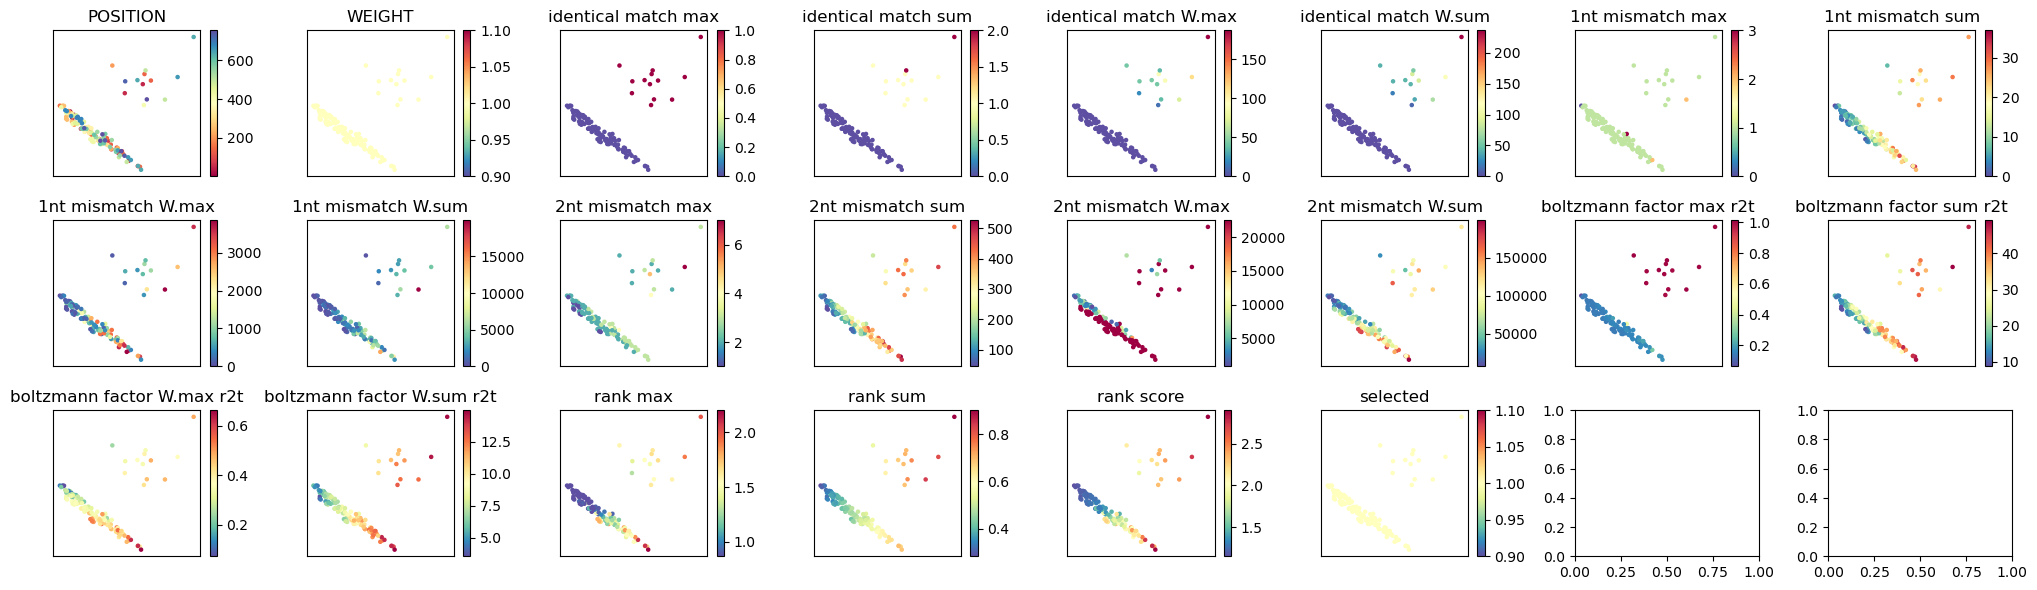

In [ ]:
### Selection stage 1 ### - select evenly distributed a fixed number of samples

nbins = 16
nsmallest = 8
df = DF.copy()

df['bin'] = pd.cut(df.index, bins=nbins)
selected = DF.index.isin(df.groupby('bin')['rank score'].nsmallest(nsmallest).reset_index(level=0, drop=True).index)
DF.loc[selected, "selected"] = 1
DF.loc[~selected, "selected"] = 0

df_PCA(DF)
df_PCA(DF[DF.selected == 1])
df_table(DF)


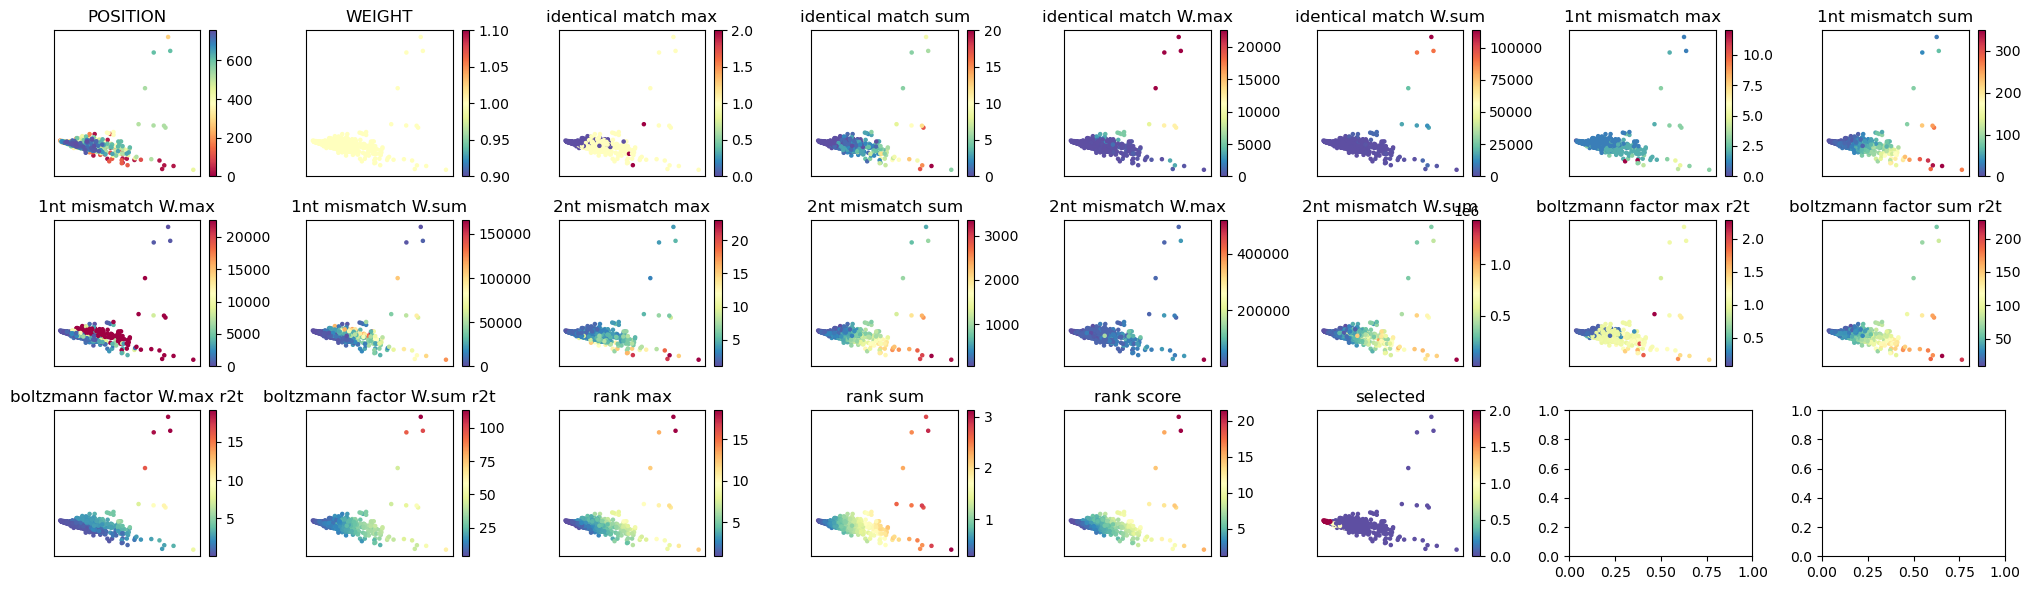

In [ ]:
min_select = 64
o = 0
df_num = DF[DF["selected"]>0].copy().select_dtypes('number').drop(["selected"]+position_cols, axis = 1)
while True:
    o += 0.001
    sel = (df_num < o*df_num.median() - (1-o)*df_num.min()).sum(axis = 1 )
    I_sel = list(sel[(sel == max(sel.max(), 1))].index)
    if len(I_sel) > min_select:
        break
DF.loc[DF.selected == 2, "selected"] = 1
DF.loc[I_sel,"selected"] = 2

df_PCA(DF)
df_table(DF) 

# Combinatorial optimization

In [ ]:
### search for offtarget binding sites of the remaining selection

query_dataset = DF[DF.selected == DF.selected.max()]
sc_refs = pd.concat([pd.DataFrame([target]), reference_dataset], axis = 0)  # include target in sequence comparison

def query_sc_wrapper(query:pd.Series, reference_dataset:pd.DataFrame)->pd.DataFrame:
    return [query, query_sc(query, reference_dataset)]

qnsc_results = list(tqdm(total=len(query_dataset), ncols = 100,
        iterable = Parallel(return_as="generator", n_jobs=-1)(
            delayed(query_sc_wrapper)(query, sc_refs) for _, query in query_dataset.iterrows() )))


100%|███████████████████████████████████████████████████████████████| 65/65 [00:11<00:00,  5.53it/s]


In [ ]:
qnsc_results[0][0]

POSITION                                                                      2
SEQ_NAME                                         iGEM_mCherry_BBa_E2060_002:014
SEQUENCE                                                           GGCAACTAGCGG
WEIGHT                                                                        1
identical match max                                                         0.0
identical match sum                                                         0.0
identical match VIR                                                          []
identical match W.max                                                       0.0
identical match W.sum                                                       0.0
identical match W.VIR                                                        []
1nt mismatch max                                                            1.0
1nt mismatch sum                                                            2.0
1nt mismatch VIR                        

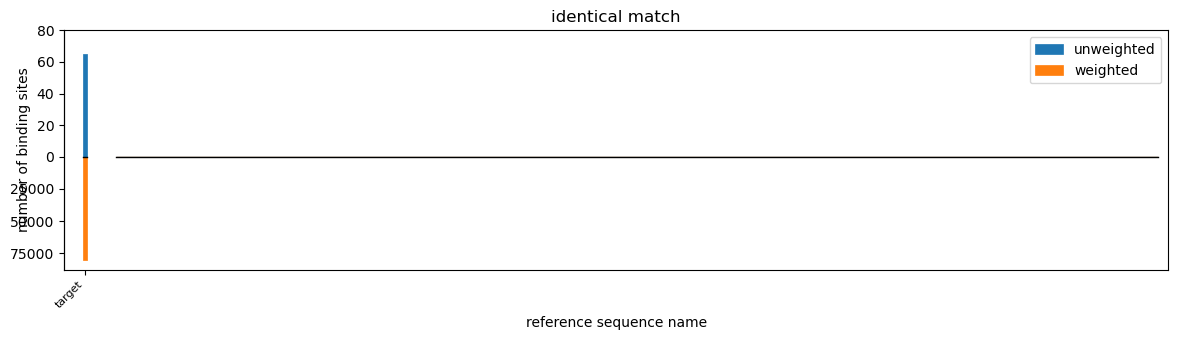

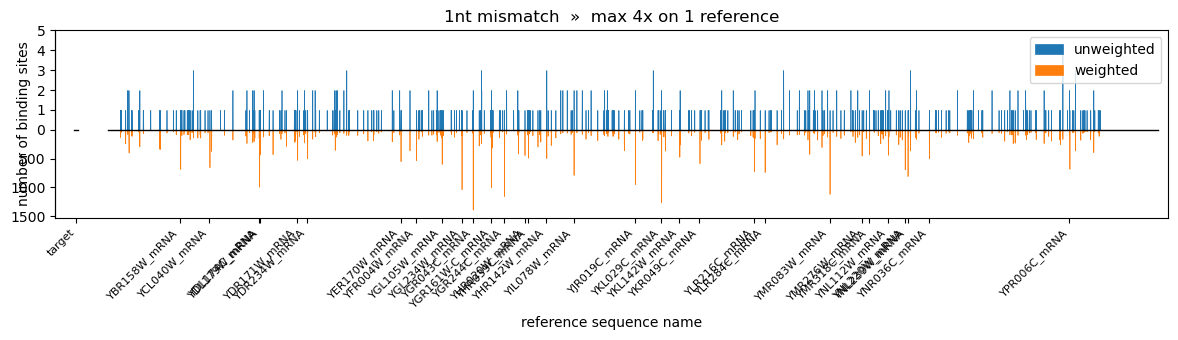

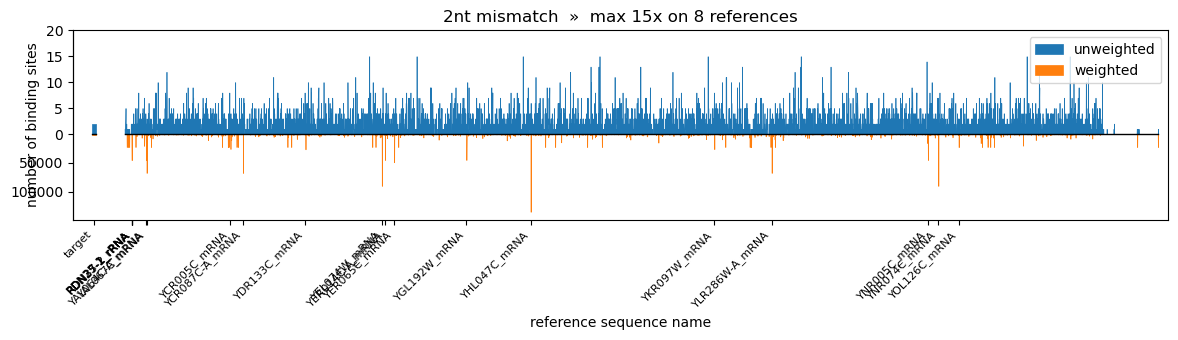

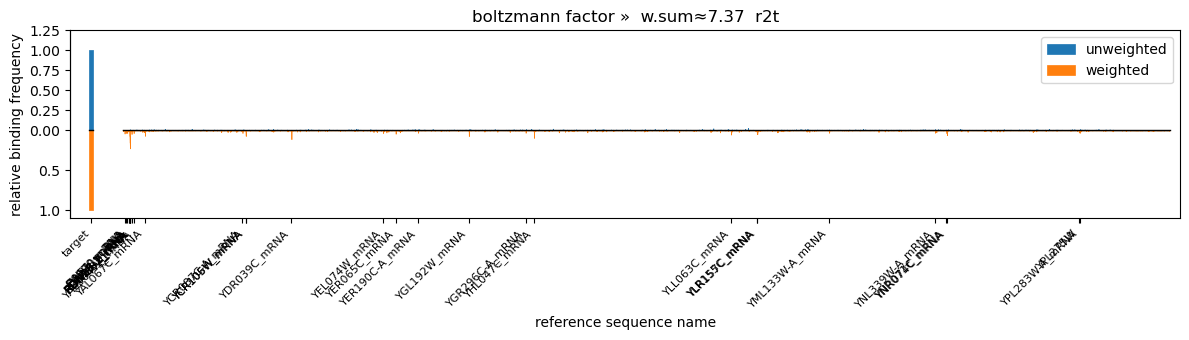

POSITION 0                                                                    2
POSITION 1                                                                    3
POSITION 2                                                                    6
POSITION 3                                                                    8
POSITION 4                                                                    9
                                                    ...                        
boltzmann factor sum r2t                                              19.425116
boltzmann factor VIR          [YLR106C_mRNA, YKR054C_mRNA, YHR099W_mRNA, YDR...
boltzmann factor W.max r2t                                             0.225189
boltzmann factor W.sum r2t                                              7.36643
boltzmann factor W.VIR        [RDN37-1_rRNA, RDN37-2_rRNA, RDN25-2_rRNA, RDN...
Length: 90, dtype: object

In [ ]:
positions = {}
metrics = ["identical match", "1nt mismatch", "2nt mismatch", "boltzmann factor"]
weight = 0
for i, (query, scr) in enumerate(qnsc_results):
    positions |= {f"POSITION {i}": query.POSITION}
    weight += query.WEIGHT
    if i == 0:
        references_scr = scr.loc[~(scr.SEQ_NAME == target.SEQ_NAME)].reset_index(drop = True)  # results from the comparison with the reference dataset (sequences to avoid)
        target_scr     = scr.loc[  scr.SEQ_NAME == target.SEQ_NAME ].reset_index(drop = True).iloc[0]  # results from the comparison with the target sequence
    else:
        references_scr[metrics] += scr.loc[~(scr.SEQ_NAME == target.SEQ_NAME)].reset_index(drop = True)[metrics]  # results from the comparison with the reference dataset (sequences to avoid)
        target_scr[metrics]     += scr.loc[  scr.SEQ_NAME == target.SEQ_NAME ].reset_index(drop = True).iloc[0][metrics]  # results from the comparison with the target sequence

sc_summarize(pd.Series(positions|{"WEIGHT": weight}), references_scr,  target_scr, plot = True, VIR_max = 32) # summary of all candidates together

### evaluate all permutations of *n* queries

In [ ]:
from itertools import combinations
metrics = ["identical match", "1nt mismatch", "2nt mismatch", "boltzmann factor"]

def combo_summarize(combo_sc_results, use_weights: bool = True, VIR_max: int = 32, r2t: bool = True):
    positions = {}
    sequences = {}
    seq_names = {}
    weight = {"WEIGHT": 0}
    for i, (query, scr) in enumerate(combo_sc_results):
        positions |= {f"POSITION {i}": query.POSITION}
        sequences |= {f"SEQUENCE {i}": query.SEQUENCE}
        seq_names |= {f"SEQ_NAME {i}": query.SEQ_NAME}
        weight["WEIGHT"] += query.WEIGHT

        if i == 0:
            references_scr = scr.loc[~(scr.SEQ_NAME == target.SEQ_NAME)].reset_index(drop = True)  # results from the comparison with the reference dataset (sequences to avoid)
            target_scr     = scr.loc[  scr.SEQ_NAME == target.SEQ_NAME ].reset_index(drop = True).iloc[0]  # results from the comparison with the target sequence
        else:
            references_scr[metrics] += scr.loc[~(scr.SEQ_NAME == target.SEQ_NAME)].reset_index(drop = True)[metrics]  # results from the comparison with the reference dataset (sequences to avoid)
            target_scr[metrics]     += scr.loc[  scr.SEQ_NAME == target.SEQ_NAME ].reset_index(drop = True).iloc[0][metrics]  # results from the comparison with the target sequence
    return sc_summarize(pd.Series(positions | sequences | seq_names | weight), references_scr,  target_scr, use_weights=use_weights, VIR_max=VIR_max, r2t=r2t, plot = False)


##### round 1 - all permutations of 2 pumbys

In [ ]:
### search for offtarget binding sites of permutations from remaining selection

n_query = 2
min_distance = 64

qnscr_dict = {qnsc_results[i][0].POSITION: qnsc_results[i] for i in range(len(qnsc_results))}                                                              
query_combos = [(p1, p2) for p1, p2 in list(combinations(qnscr_dict.keys(), n_query)) if abs(p1-p2) > min_distance]  # compute all possible combinations of 2 queries i.e. binding sites, but make sure there is a bit of space inbetween

combo_sc_data = [[qnscr_dict[query_position] for query_position in query_combo] for query_combo in query_combos]  # prepare sequence comparison results from earlier in the groups of two
qc_results = pd.DataFrame([combo_summarize(csd) for csd in tqdm(combo_sc_data, total = len(combo_sc_data), ncols = 100)]) # evaluate the combined sequence comparison results for each group of queries

100%|███████████████████████████████████████████████████████████| 1734/1734 [00:28<00:00, 61.79it/s]


257


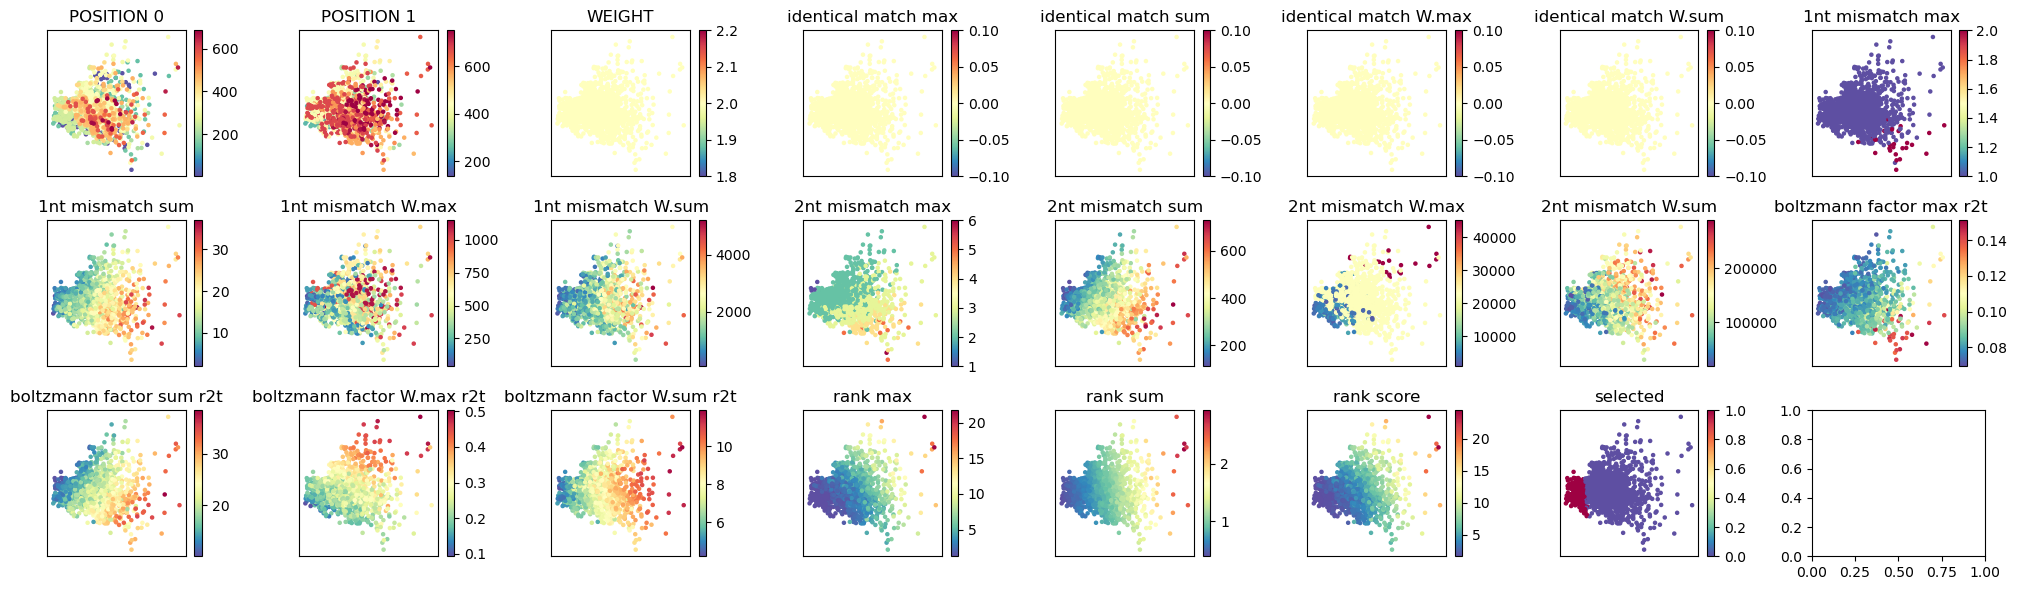

In [ ]:
DF = qc_results
min_select = 256


position_cols = [col for col in DF.columns if col.startswith("POSITION")]
DFnum = DF.select_dtypes(np.number).drop(position_cols, axis = 1)
rel_ranks = (DFnum.rank() + DFnum.rank(method = "dense"))/ (2*len(DF) +1) # relative total number, i.e. within 0...1
weighted_ranks = 2**(rel_ranks.apply(stats.norm.ppf)) * DFnum.apply(_col_weights)  


DF["rank max"] = weighted_ranks.max(axis = 1) 
DF["rank sum"] = weighted_ranks.mean(axis = 1)  
DF["rank score"] = DF["rank max"] +  DF["rank sum"]
DF["selected"] = 0


df = DF.copy()

DF_num = DF.copy().select_dtypes('number').drop(["selected"]+position_cols, axis = 1)
df_num = DF_num.copy()
for o in np.arange(0, 1, 0.001):
    _quant = (df_num < (1-o)*DF_num.median() - (o)*DF_num.min()).sum(axis = 1 )
    if len(df_num) - (_quant == _quant.min()).sum() > min_select:
        df_num = df_num.drop(_quant[_quant == _quant.min()].index)

DF.loc[DF.selected == 1, "selected"] = 0
DF.loc[df_num.index,"selected"] = 1

print(sum(DF.selected == 1))
df_PCA(DF)
df_table(DF, ignore_columns_like = ["VIR", "SEQ_NAME", "SEQUENCE"])


### round 2 finding good tetramers

5067/28639 fullfilled min-distance of 64


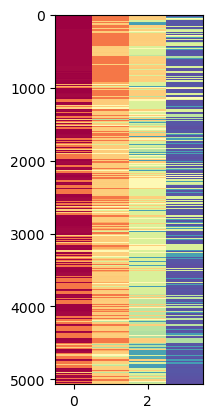

In [ ]:
selected = DF[DF.selected == 1]
query_combos = []
n = 0
for set1, set2 in combinations(selected.apply(lambda row: set((row['POSITION 0'], row['POSITION 1'])), axis=1).values, 2):
    union = np.sort(list(set1 | set2))
    if len(union) == 4:
        n += 1
        if ((union[1:]-union[:-1]) > min_distance).all():
            query_combos.append(tuple(set1 | set2))

query_combos = list(set(query_combos))
query_combos.sort()
query_combos = [np.sort(qc).tolist() for qc in query_combos]
plt.imshow(query_combos, cmap = "Spectral", interpolation="nearest", aspect = 10/len(query_combos));
print(f"{len(query_combos)}/{n} fullfilled min-distance of {min_distance}")

In [ ]:
combo_sc_data = [[qnscr_dict[query_position] for query_position in query_combo] for query_combo in query_combos]  # prepare sequence comparison results from earlier in the groups of two
qc_results = pd.DataFrame([combo_summarize(csd) for csd in tqdm(combo_sc_data, total = len(combo_sc_data), ncols = 100)]) # evaluate the combined sequence comparison results for each group of queries

100%|███████████████████████████████████████████████████████████| 5067/5067 [01:59<00:00, 42.37it/s]


In [ ]:
DF = qc_results

position_cols = [col for col in DF.columns if col.startswith("POSITION")]
DFnum = DF.select_dtypes(np.number).drop(position_cols, axis = 1)
rel_ranks = (DFnum.rank() + DFnum.rank(method = "dense"))/ (2*len(DF) +1) # relative total number, i.e. within 0...1
weighted_ranks = 2**(rel_ranks.apply(stats.norm.ppf)) * DFnum.apply(_col_weights)  

DF["rank max"] = weighted_ranks.max(axis = 1) 
DF["rank sum"] = weighted_ranks.mean(axis = 1)  
DF["rank score"] = DF["rank max"] +  DF["rank sum"]
DF["selected"] = 0

min_select = 4
DF_num = DF.copy().select_dtypes('number').drop(["selected"]+position_cols, axis = 1)
df_num = DF_num.copy()
for o in np.arange(-1, 1, 0.001):
    _quant = (df_num < (1-o)*DF_num.median() - (o)*DF_num.min()).sum(axis = 1 )
    if len(df_num) - (_quant == _quant.min()).sum() > min_select:
        df_num = df_num.drop(_quant[_quant == _quant.min()].index)

DF.loc[DF.selected == 1, "selected"] = 0
DF.loc[df_num.index,"selected"] = 1


df_table(DF, ignore_columns_like = ["VIR", "SEQ_NAME"])




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0150: ACCCAAACCGCG
0248: CAAGCACCCCGC
0425: CGGCCCGGTTAT
0675: AGGGCTGAGGGG


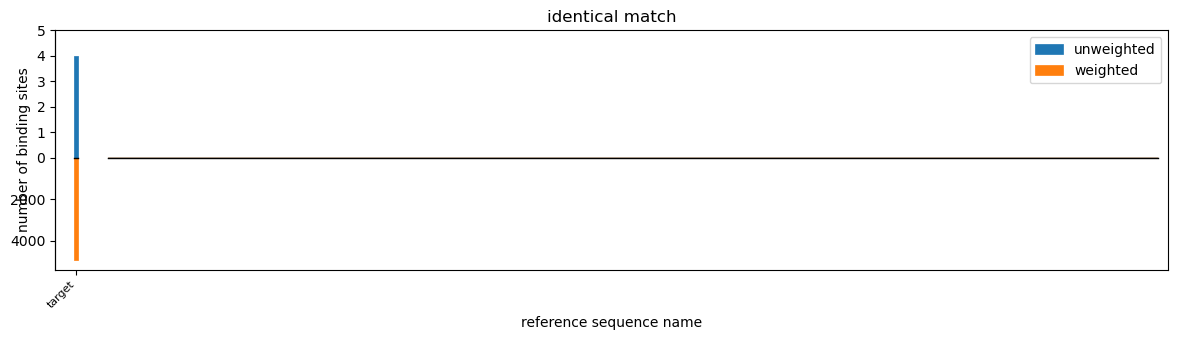

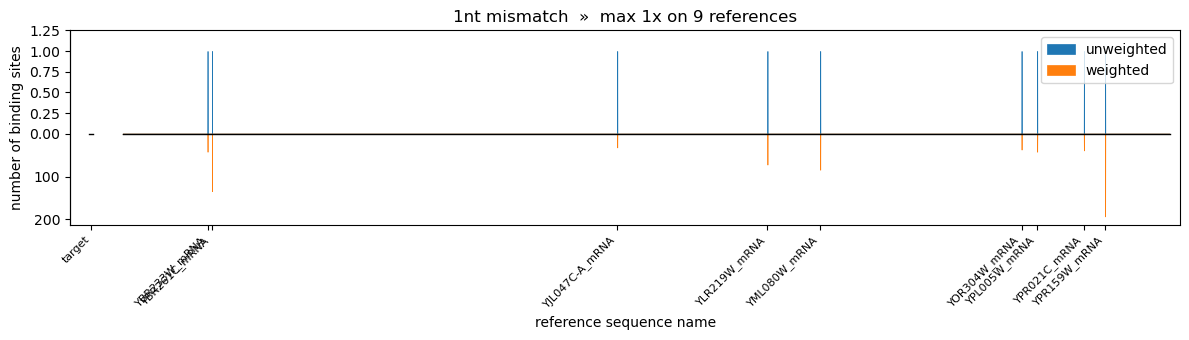

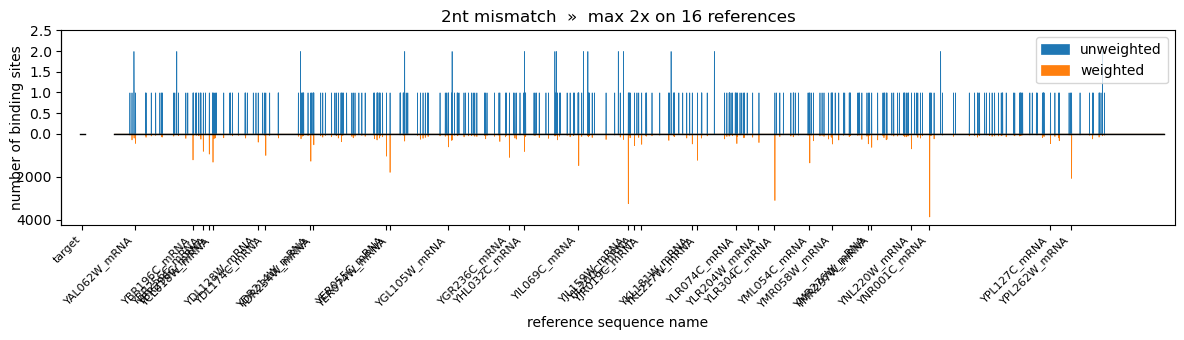

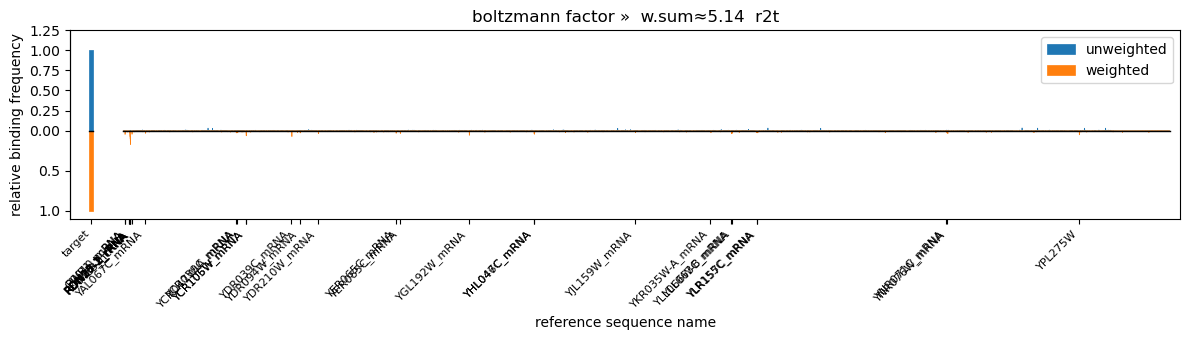



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0150: ACCCAAACCGCG
0248: CAAGCACCCCGC
0425: CGGCCCGGTTAT
0676: GGGCTGAGGGGA


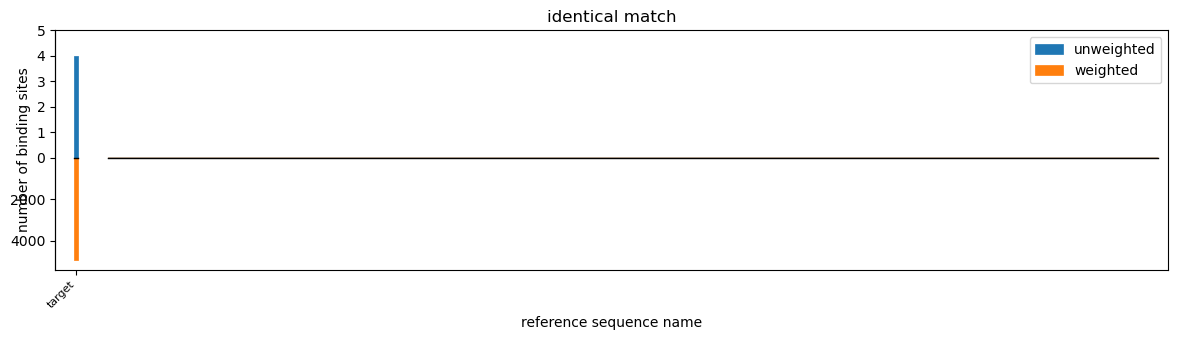

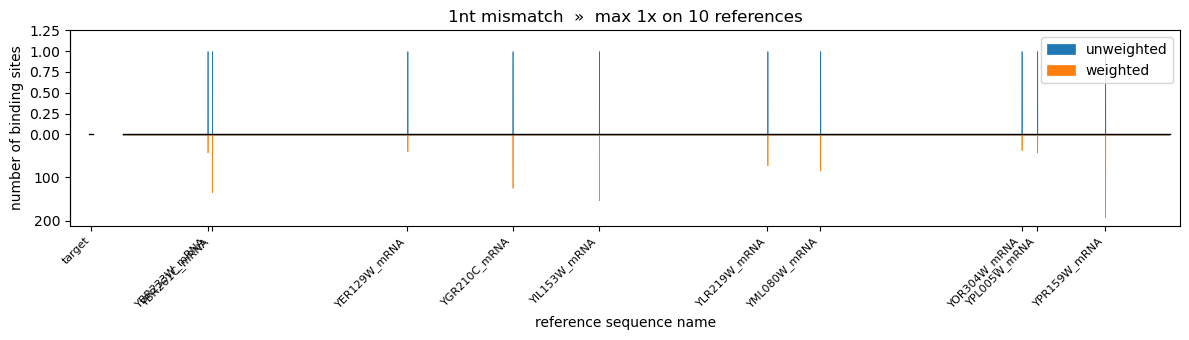

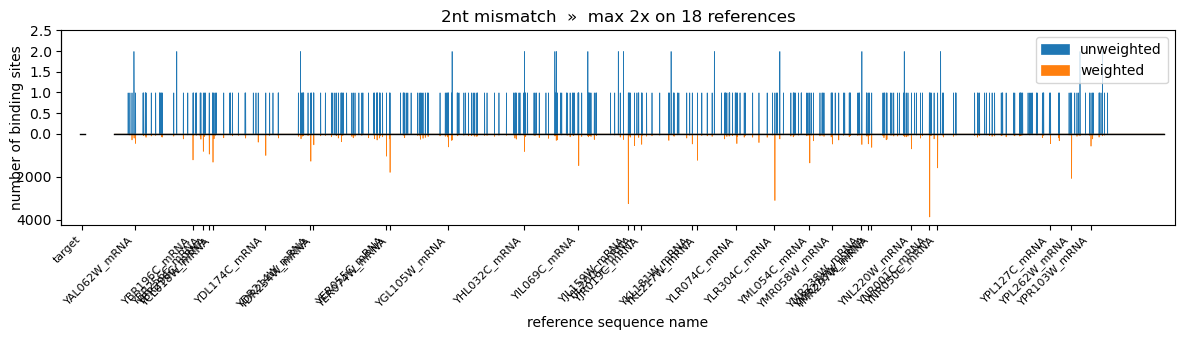

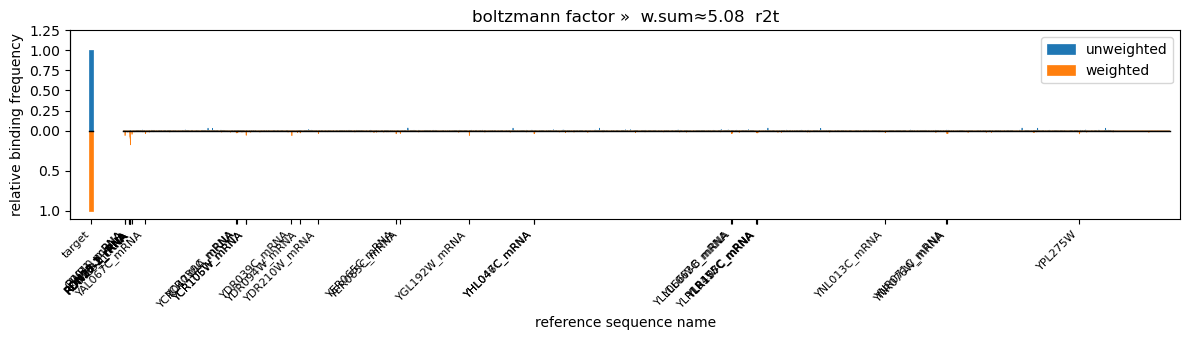



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0150: ACCCAAACCGCG
0249: AAGCACCCCGCC
0425: CGGCCCGGTTAT
0675: AGGGCTGAGGGG


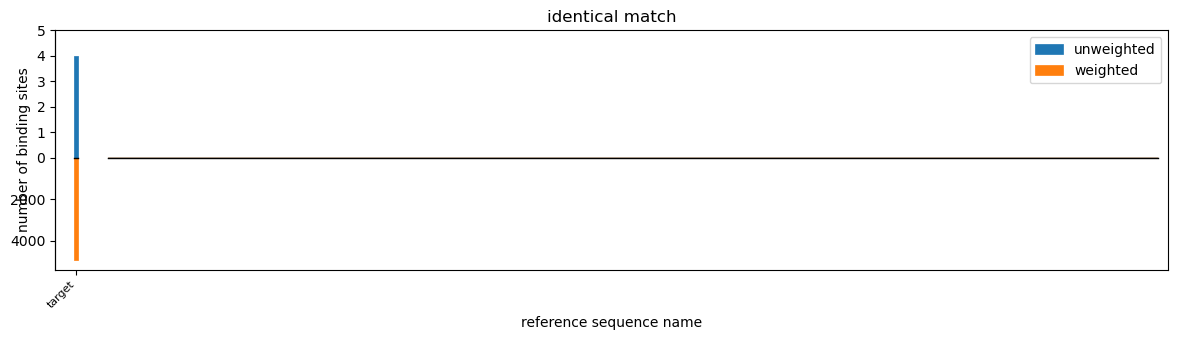

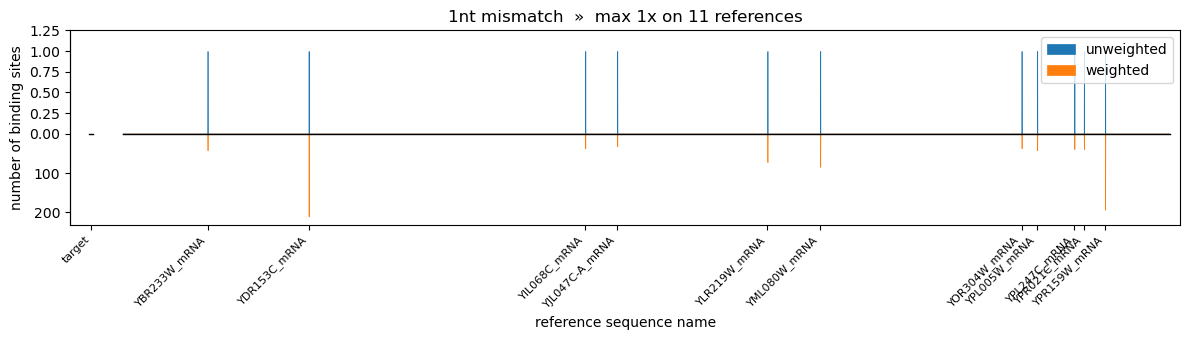

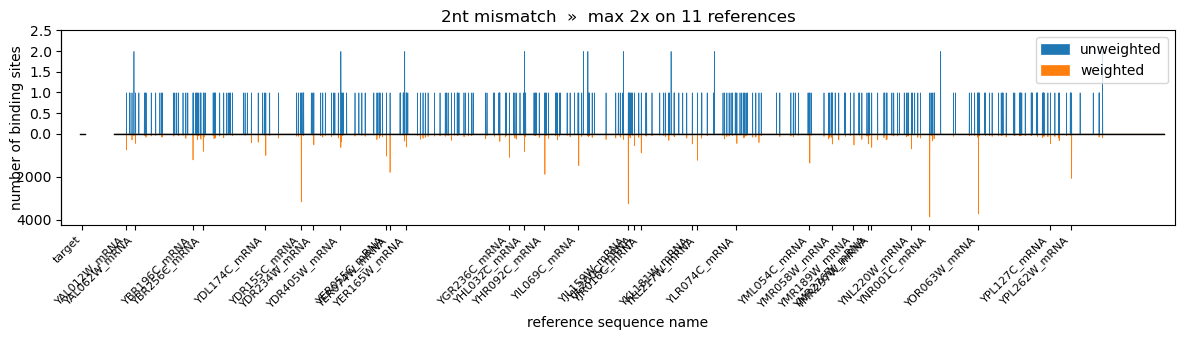

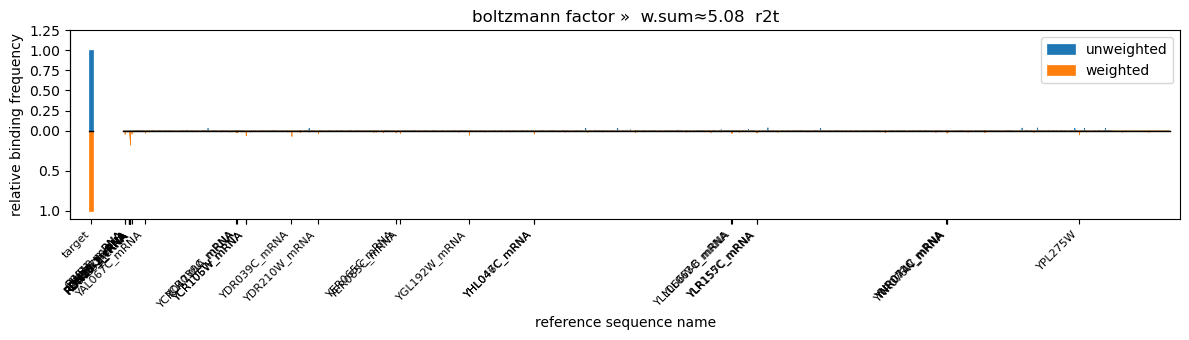



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0150: ACCCAAACCGCG
0249: AAGCACCCCGCC
0425: CGGCCCGGTTAT
0675: AGGGCTGAGGGG


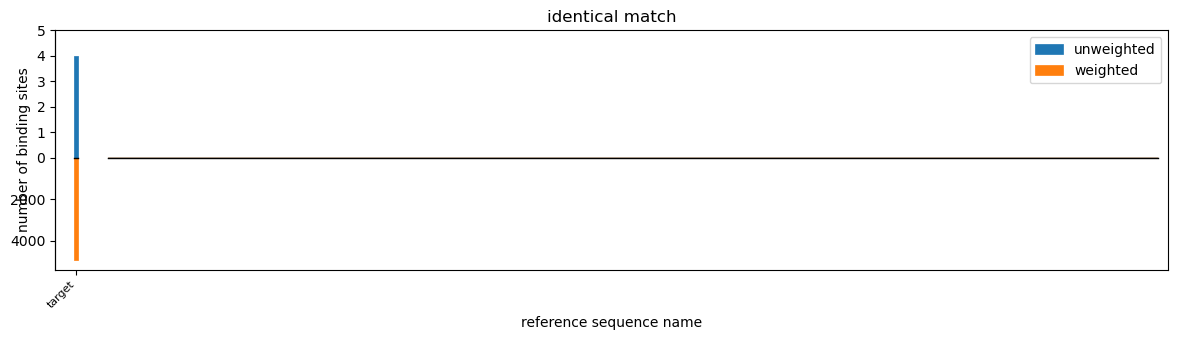

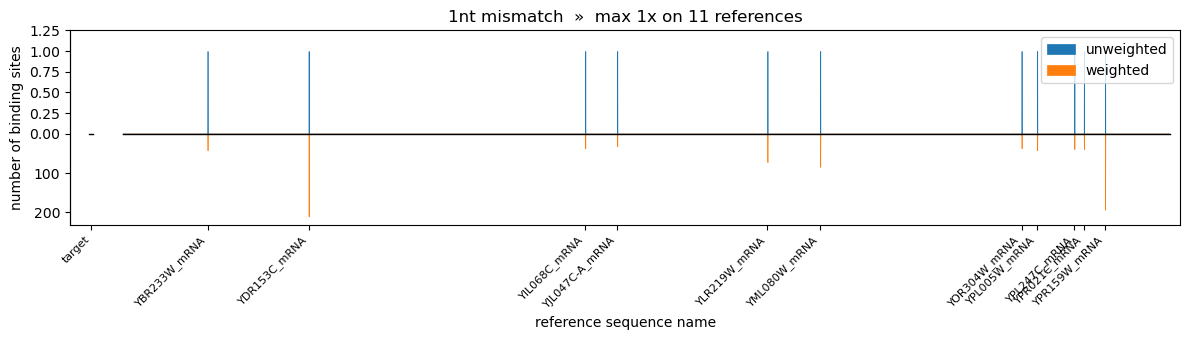

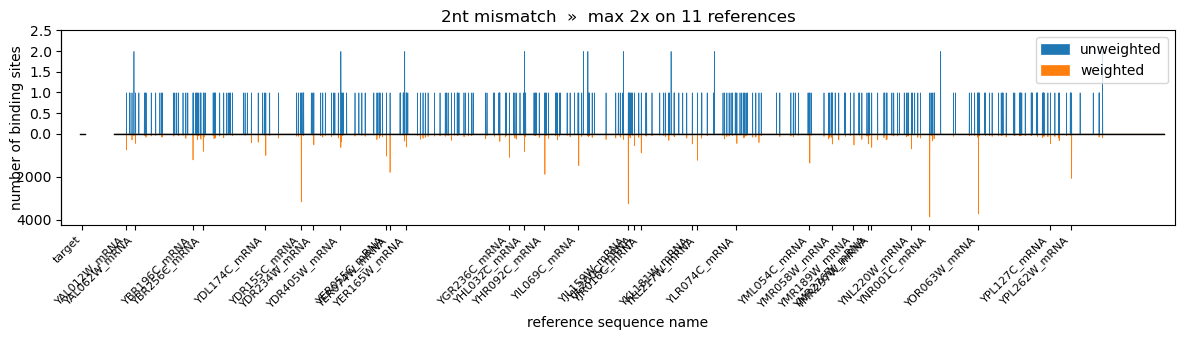

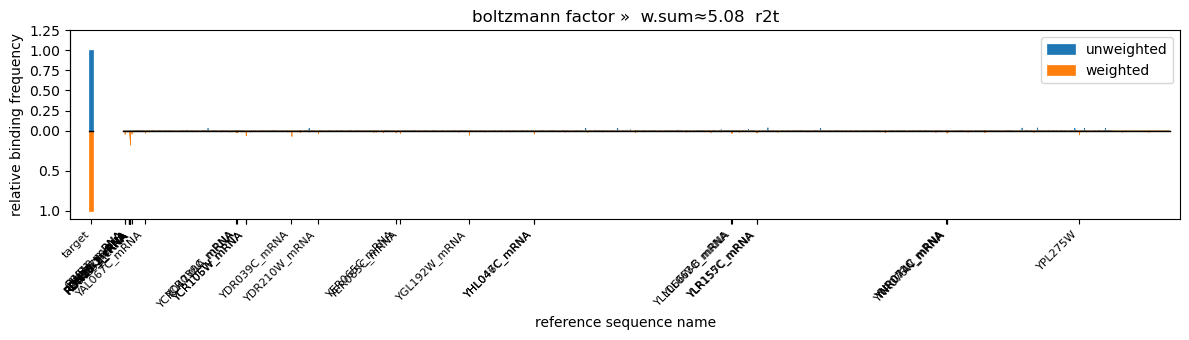



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0150: ACCCAAACCGCG
0249: AAGCACCCCGCC
0425: CGGCCCGGTTAT
0675: AGGGCTGAGGGG


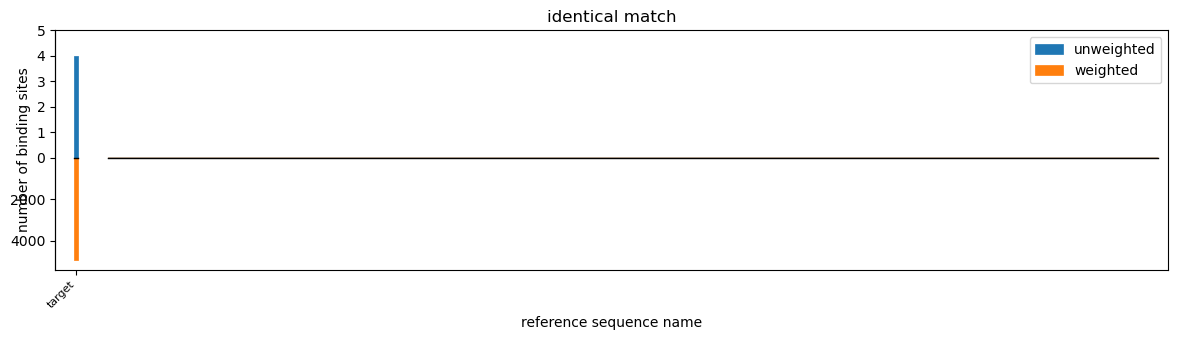

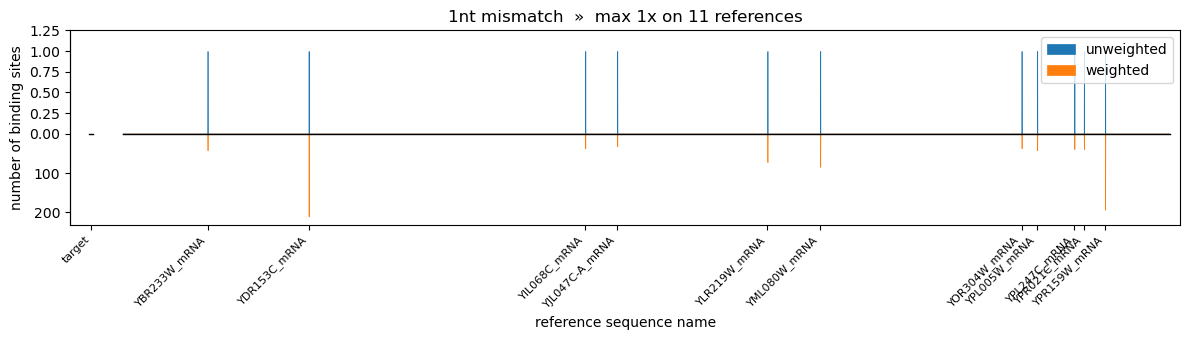

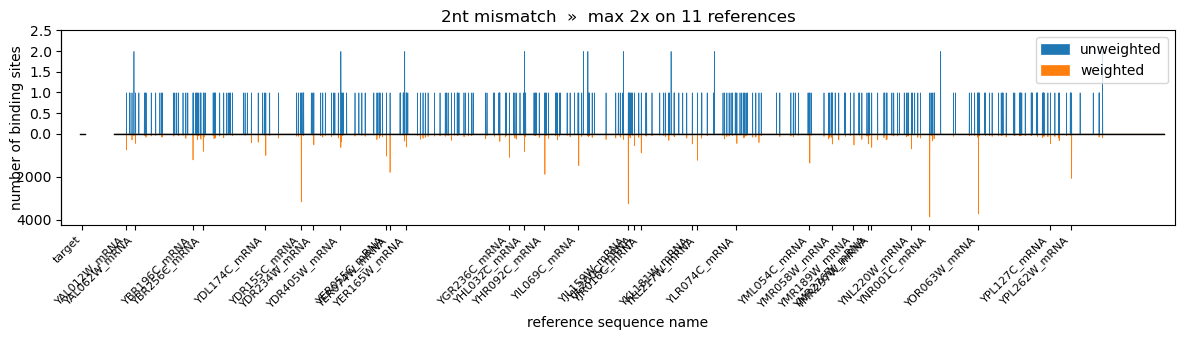

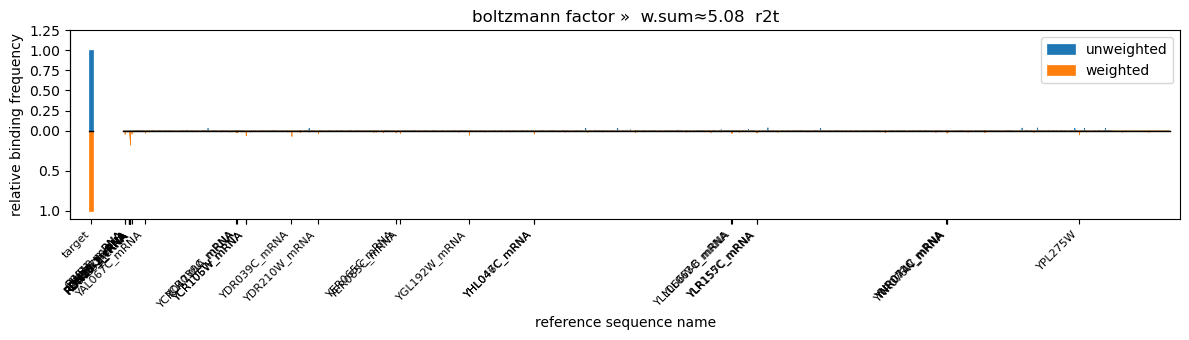

In [ ]:
df = DF[DF.selected == 1]
for _, qc_indices in df.filter(like="POSITION").iterrows():
    positions = {}
    metrics = ["identical match", "1nt mismatch", "2nt mismatch", "boltzmann factor"]
    weight = 0
    print("\n")
    print("---"*100)
    for i, (query, scr) in enumerate([qnscr_dict[position] for position in qc_indices.values]):
        positions |= {f"POSITION {i}": query.POSITION}
        weight += query.WEIGHT
        print(f"{query.POSITION:04d}: {query.SEQUENCE}")
        if i == 0:
            references_scr = scr.loc[~(scr.SEQ_NAME == target.SEQ_NAME)].reset_index(drop = True)  # results from the comparison with the reference dataset (sequences to avoid)
            target_scr     = scr.loc[  scr.SEQ_NAME == target.SEQ_NAME ].reset_index(drop = True).iloc[0]  # results from the comparison with the target sequence
        else:
            references_scr[metrics] += scr.loc[~(scr.SEQ_NAME == target.SEQ_NAME)].reset_index(drop = True)[metrics]  # results from the comparison with the reference dataset (sequences to avoid)
            target_scr[metrics]     += scr.loc[  scr.SEQ_NAME == target.SEQ_NAME ].reset_index(drop = True).iloc[0][metrics]  # results from the comparison with the target sequence

    sc_summarize(pd.Series(positions|{"WEIGHT": weight}), references_scr,  target_scr, plot = True, VIR_max = 32) 

# todo
 - generalize combinatorial optimization to k-mers
 - include the secondary structure induced binding strength
 - better model for especially the effect of multiple offtarget binding sites per transcriptom
 - documentation of new search functions and combinatorial optimization
